In [ ]:
import cv2
import numpy as np
import pickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook as tqdm
import time
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
from nltk.cluster.kmeans import KMeansClusterer
import nltk

from IPython.display import clear_output

Main parameters of the code

In [17]:
n_descriptors = 600
codebook_size = 128
n_neighbors = 6
# Now all knn_metrics are computed at the end of the notebook
# knn_metric = 'minkowski' # euclidean, manhattan, chebyshev, minkowski, bhatt
# More knn_metrics can be found at: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html

descriptor_type = 'sift' # sift, surf
dense_descriptors = True
rootSift = True
scale_mode = "gauss" # random, uniform, gauss

#SURF Params
minHessian = 100

#SIFT Params
maxScale = 15
minScale = 7
#if sift version is dense
stepValue = 10
mean = 15
desvt= 7

# root sift options
eps = 1e-7

# KMeans Clusterer Options
used_kmeans = "mini_batch" # mini_batch, nlkt
distance_kmeans = "corr" # Only for nlkt


start = time.clock()

### Definitions & Implementations

In [18]:
cv2distances = {"corr":cv2.HISTCMP_CORREL,
                "chi":cv2.HISTCMP_CHISQR_ALT,
                "inter":cv2.HISTCMP_INTERSECT,
                "bhatt":cv2.HISTCMP_BHATTACHARYYA,
                "chialt":cv2.HISTCMP_CHISQR_ALT,
                "kl_div": cv2.HISTCMP_KL_DIV
               }
dist_name_list = ["euclidean", "manhattan", "chebyshev", "minkowski","hamming","canberra","braycurtis"] + list(cv2distances.keys())

def dense_keypoints(img,step, scaleMin, scaleMax):
    keypoints = []
    heigh, width = img.shape
    for i in range( 0, heigh, step):
        for j in range( 0, width, step):
            if(scale_mode=="random"):
                scale = np.random.rand()
            elif(scale_mode == "uniform"):
                scale = random.uniform(scaleMin,scaleMax) #maybe another type of randomness? 
            elif(scale_mode=="gauss"):
                scale = abs(random.gauss(mean,desvt))
            else:
                raise(ValueError("scale mode undefined"))

            keypoints.append( cv2.KeyPoint(j,i, scale))
    return keypoints

def get_keypoints(im):
    if(dense_descriptors):
        kpt = dense_keypoints(im, stepValue, maxScale, minScale)
    else:
        if(descriptor_type=='sift'):
            kpt = detectorObject.detect(im)
        elif(descriptor_type=="surf"):
            kpt = detectorObject.detect(im)
        else:
             raise(NotImplemented("detector_type not implemented or not recognized:"+str(descriptor_type)))
    return kpt
            
def get_descriptors(im, kpt):
    if(descriptor_type=='sift'):
        kpt,des = detectorObject.compute(im,kpt)
        if(rootSift):
            des /= (des.sum(axis=1, keepdims=True) + eps)
            des = np.sqrt(des) 
    elif(descriptor_type=="surf"):
        kpt,des = detectorObject.compute(im,kpt)
    return kpt, des
    
def get_dist_func(name, force_function=False):
    if name in cv2distances.keys():
        def func(x1,x2):
            print("X1:", x1.shape, type(x1))
            print("X2:", x1.shape, type(x2))
            dist = cv2.compareHist(x1, x2, cv2distances[name])
            print(dist)
            return dist
        KNN_METRIC = func
        
        #KNN_METRIC = lambda x1, x2: cv2.compareHist(x1, x2, cv2distances[name])
    elif not force_function:
        KNN_METRIC = name
    else:
        dist = DistanceMetric.get_metric(name)
        distlambda = lambda x, y : dist.pairwise((x,y))
        KNN_METRIC = distlambda
        
    return KNN_METRIC
    
def get_descriptors_dataset(filenames):
    descriptors = []
    #Train_label_per_descriptor = []
    
    visual_words=np.zeros((len(filenames),codebook_size),dtype=np.float32)
    for i in tqdm(range(len(filenames)),desc="Calc Desc:"):
    #for filename,labels in zip(tqdm(train_images_filenames,desc="Progress"),train_labels):
        ima=cv2.imread(filenames[i])
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        kpt = get_keypoints(gray)
        kpt, des = get_descriptors(gray, kpt)
        descriptors.append(des)
        #Train_label_per_descriptor.append(labels[i])
    D=np.vstack(descriptors)
    return D, descriptors

def get_bag_of_words(desc_list):
    # And, for eacohh train image, we project each keypoint descriptor to its closest visual word. 
    # We represent each of the images with the frequency of each visual word.
    vw_array=np.zeros((len(desc_list),codebook_size),dtype=np.float32)
    for i in tqdm(range(len(desc_list)), desc="Calc  BoW:"):
        words=codebook.predict(desc_list[i])
        vw_array[i,:]=np.bincount(words,minlength=codebook_size)
    return vw_array

### Extra functions

In [19]:
conf_mat_list = []

def print_res(names, accuracies, times):
    """
    Function used when showing results 
    """
    def get_ristra_string(l, find_highest=False):
        string = ""
        for v in l:
            if(isinstance(v, float)):
                substring = "{0:.2f}".format(v)[:4]
                if(find_highest and v == max([x for x in l if isinstance(x, float)])):
                    substring = substring+"*"      
            else:
                substring=v[:4]
            string+=substring+"\t"
        return string+"\n"
    s  = "     \t"+get_ristra_string(names)
    s += " Acc:\t"+get_ristra_string(accuracies, True)
    s += "Time:\t"+get_ristra_string(times, False)
    clear_output()
    print(s)

Let us first read the train and test files


In [6]:
train_images_filenames = pickle.load(open('./train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('./test_images_filenames.dat','rb'))
train_labels = pickle.load(open('./train_labels.dat','rb'))
test_labels = pickle.load(open('./test_labels.dat','rb'))


We create a SIFT object detector and descriptor


In [22]:
if(descriptor_type=='sift'):
    detectorObject = cv2.xfeatures2d.SIFT_create(nfeatures=n_descriptors)
elif(descriptor_type=="surf"):
    detectorObject = cv2.xfeatures2d.SURF_create()
else:
    raise(NotImplemented("detector_type not implemented or not recognized:"+str(descriptor_type)))

#dense_detector = cv2.FeatureDetector_create("Dense")

### TRAIN DESCRIPTORS CALCULATION

In [24]:
# We compute the SIFT descriptors for all the train images and subsequently 
# build a numpy array with all the descriptors stacked together
D, dlist = get_descriptors_dataset(train_images_filenames)

error: OpenCV(3.4.2) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


### Creation of Descriptor Object

In [ ]:
class KMeansDistances(KMeansClusterer):
    """
    KMeansClusterer adaptation to use same sintax as MiniBatchKMeans
    Implementation of KMeans that allows using distances.
    """
    def __init__(self, *args, **kwargs):
        args+=( nltk.cluster.util.cosine_distance,)
        super().__init__( *args, **kwargs)
    def fit(self, data):
        return self.cluster(data, True, trace=True)
    def predict(self, vector):
        return self.classify_vectorspace(vector)
    
# We now compute a k-means clustering on the descriptor space
reassignment_ratio=10**-4
if(used_kmeans=="mini_batch"):
    codebook = MiniBatchKMeans(n_clusters=codebook_size, verbose=False, batch_size=codebook_size * 20,compute_labels=False,reassignment_ratio=reassignment_ratio,random_state=42)
elif(used_kmeans=="nlkt"):
    DIST = get_dist_func(distance_kmeans,True)
    #codebook = KMeansDistances(codebook_size, DIST, repeats=10)
    codebook = KMeansDistances(codebook_size, repeats=10)
else:
    raise(ValueError("KMeans not recognized"))
codebook.fit(D)

In [10]:
visual_words = get_bag_of_words(dlist)

### K-MEANS CLUSTERING OF DESCRIPTORS


In [11]:
codebook.fit(D)

MiniBatchKMeans(batch_size=2560, compute_labels=False, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=128, n_init=3, random_state=42,
        reassignment_ratio=0.0001, tol=0.0, verbose=False)

### COMPUTE TEST DESCRIPTORS

In [12]:
T, tlist = get_descriptors_dataset(test_images_filenames)
visual_words_test = get_bag_of_words(tlist)

### BUILD OF K-NN CLASSIFIER

In [13]:
# We build a k-nn classifier and train it with the train descriptors
names_proc = []
accuracies_proc = []
times_proc = []
errors_proc = []
for knn_metric in dist_name_list:
    #printmd("### "+knn_metric)
    names_proc.append(knn_metric)
    #try:
    KNN_METRIC = get_dist_func(knn_metric)
    knn = KNeighborsClassifier(n_neighbors=n_neighbors,n_jobs=-1,metric=KNN_METRIC)
    knn.fit(visual_words, train_labels) 

    accuracy = 100*knn.score(visual_words_test, test_labels)
    #print(accuracy)
    #print ("Time since first block was executed:", time.clock() - start)
    accuracies_proc.append(accuracy)
    test_predict_labels = knn.predict(visual_words_test)
    labels_names = list(set(test_labels))

    conf_mat_list.append(confusion_matrix( test_labels, test_predict_labels, labels=labels_names))
    #except Exception as e:
#        accuracies_proc.append("E")
#        errors_proc.append((knn_metric, e))
    times_proc.append(time.clock() - start)
    print_res(names_proc, accuracies_proc, times_proc)
printmd("### Errors")
for name, error in errors_proc:
    printmd("#### "+name)
    printmd('<span style="color:red"> **Error:** </span>'+str(error))

     	eucl	manh	cheb	mink	hamm	canb	bray	
 Acc:	75.5	75.8	68.1	75.5	43.1	69.3	76.2*	
Time:	1424	1425	1425	1426	1427	1429	1429	

X1: (128,) <class 'numpy.ndarray'>
X2: (128,) <class 'numpy.ndarray'>


error: OpenCV(3.4.2) C:\projects\opencv-python\opencv\modules\imgproc\src\histogram.cpp:1935: error: (-215:Assertion failed) H1.type() == H2.type() && H1.depth() == 5 in function 'cv::compareHist'


In [14]:
res = get_dist_func("bhatt")(visual_words[1],visual_words_test[1])

X1: (128,) <class 'numpy.ndarray'>
X2: (128,) <class 'numpy.ndarray'>
0.6208488144261152


In [15]:
visual_words[1].dtype

dtype('float32')

### Show Confusion Matrix

### braycurtis

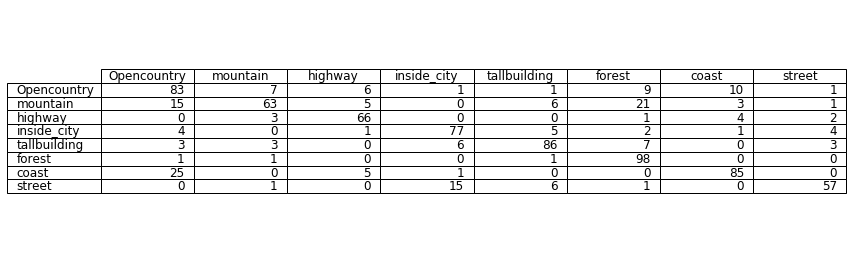

In [16]:
show_matrix = "bray"
for i, dist_name in enumerate(dist_name_list):
    if(show_matrix[:4] == dist_name[:4]):
        printmd("### "+dist_name)
        conf = conf_mat_list[i]
        fig, axs = plt.subplots(1,1)
        axs.axis('tight')
        axs.axis('off')
        the_table = axs.table(cellText=conf, rowLabels=labels_names, colLabels=labels_names, loc='center')
        the_table.auto_set_font_size(False)
        the_table.set_fontsize(12)
        the_table.scale(2, 1)
        fig.tight_layout()
        plt.show()
